<a href="https://colab.research.google.com/github/Justin-Jonany/IndoFoodNet/blob/main/2_model_training_efficientnetv2_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoFoodNet
IndoFoodNet aims to create a neural networks model that correctly classifies images of 9 differet Padang food. The dataset is taken from https://www.kaggle.com/datasets/faldoae/padangfood.

</br>

This notebook aims to create models to classify images into the correct labels based on **EfficientNetV2B0**

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import pandas as pd

## Helper Functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()



def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Load Data

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/processed_data/b0_'
train_data = tf.data.Dataset.load(path + 'train_data')
test_data = tf.data.Dataset.load(path + 'test_data')
val_data = tf.data.Dataset.load(path + 'val_data')

In [ ]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/splitted_data/train/'
class_names = os.listdir(train_dir)

## Creating Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.005,
                                                  patience=4)

# Set checkpoint path
checkpoint_path = 'checkpoints/checkpoint'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch', # Save every epoch
                                                         verbose=1)



## Setup mixed prevision training

In [ ]:
# Turn on mixed prevision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Base Model

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

metrics = [tf.keras.metrics.F1Score(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           'accuracy'
          ]

In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_0 = tf.keras.Model(inputs, outputs)


# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics
                )

In [ ]:
history_0 = model_0.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/25
21/21 [==============================] - 13s 206ms/step - loss: 1.7831 - f1_score: 0.4629 - precision_5: 1.0000 - recall_5: 0.0015 - accuracy: 0.4583 - val_loss: 1.3594 - val_f1_score: 0.7176 - val_precision_5: 1.0000 - val_recall_5: 0.0222 - val_accuracy: 0.7222
Epoch 2/25
21/21 [==============================] - 1s 65ms/step - loss: 1.0423 - f1_score: 0.8197 - precision_5: 1.0000 - recall_5: 0.2176 - accuracy: 0.8210 - val_loss: 0.9336 - val_f1_score: 0.7990 - val_precision_5: 1.0000 - val_recall_5: 0.4111 - val_accuracy: 0.8000
Epoch 3/25
21/21 [==============================] - 1s 67ms/step - loss: 0.7008 - f1_score: 0.8886 - precision_5: 0.9921 - recall_5: 0.5787 - accuracy: 0.8889 - val_loss: 0.7360 - val_f1_score: 0.8022 - val_precision_5: 0.9636 - val_recall_5: 0.5889 - val_accuracy: 0.8000
Epoch 4/25
21/21 [==============================] - 1s 61ms/step - loss: 0.5318 - f1_score: 0.9322 - precision_5: 0.9896 - recall_5: 0.7346 - accuracy: 0.9321 - val_loss: 0.6289 -

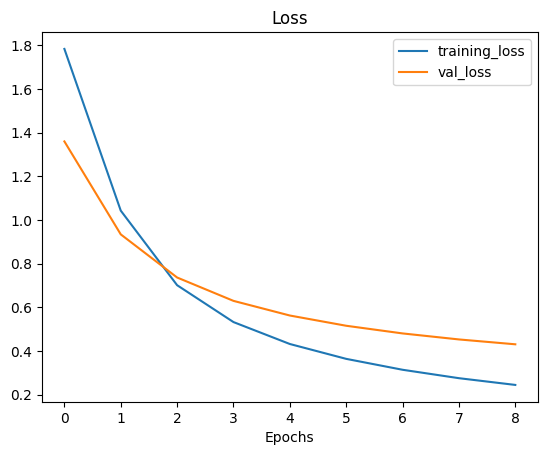

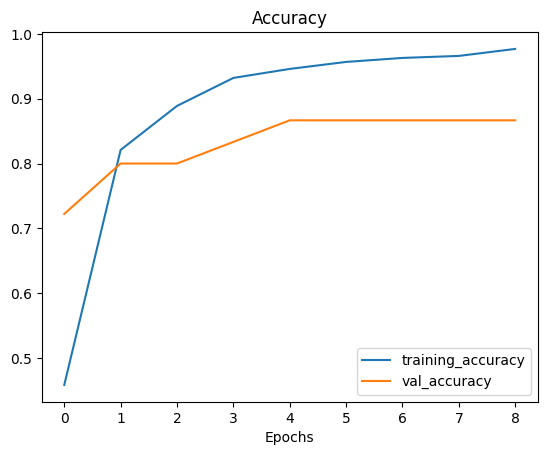

In [ ]:
plot_loss_curves(history_0)

It seems our model is overfitting

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 53ms/step - loss: 0.4300 - f1_score: 0.8684 - precision_5: 0.9333 - recall_5: 0.7778 - accuracy: 0.8667


[0.43001827597618103,
 array([0.88888896, 0.95238096, 0.9       , 0.84210527, 0.7826087 ,
        0.7777778 , 0.7826087 , 0.88888896, 1.        ], dtype=float32),
 0.9333333373069763,
 0.7777777910232544,
 0.8666666746139526]

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_0')

## Model 1: Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name='data_augmentation')

In [ ]:
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics,
                )

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/25
21/21 [==============================] - 12s 152ms/step - loss: 1.7749 - f1_score: 0.5145 - precision_5: 0.9398 - recall_5: 0.1057 - accuracy: 0.4645 - val_loss: 1.3720 - val_f1_score: 0.6659 - val_precision_5: 1.0000 - val_recall_5: 0.0333 - val_accuracy: 0.6778
Epoch 2/25
21/21 [==============================] - 1s 60ms/step - loss: 1.0431 - f1_score: 0.8261 - precision_5: 1.0000 - recall_5: 0.2392 - accuracy: 0.8272 - val_loss: 0.9560 - val_f1_score: 0.7977 - val_precision_5: 1.0000 - val_recall_5: 0.4000 - val_accuracy: 0.8000
Epoch 3/25
21/21 [==============================] - 2s 86ms/step - loss: 0.7085 - f1_score: 0.8927 - precision_5: 0.9891 - recall_5: 0.5602 - accuracy: 0.8935 - val_loss: 0.7592 - val_f1_score: 0.8354 - val_precision_5: 0.9808 - val_recall_5: 0.5667 - val_accuracy: 0.8333
Epoch 4/25
21/21 [==============================] - 2s 82ms/step - loss: 0.5383 - f1_score: 0.9286 - precision_5: 0.9814 - recall_5: 0.7315 - accuracy: 0.9290 - val_loss: 0.6503 -

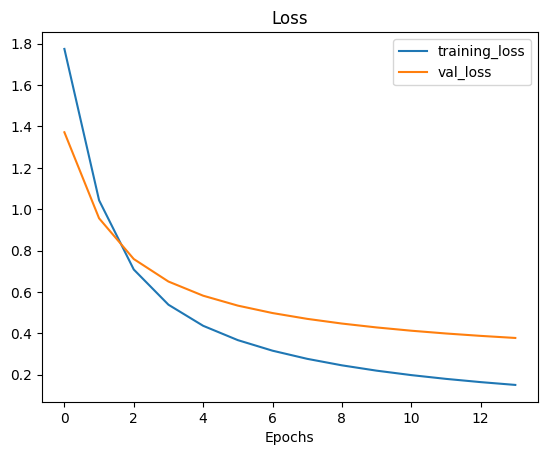

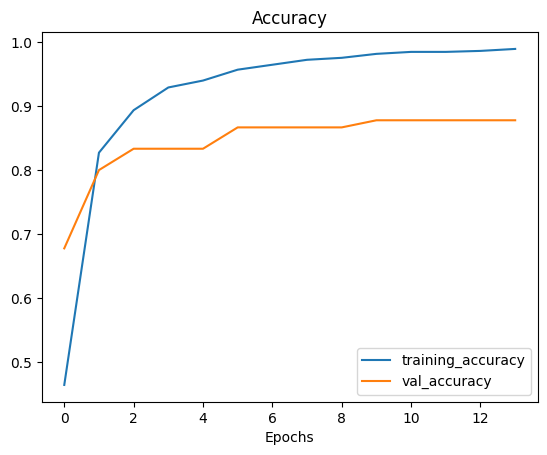

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.evaluate(val_data)

3/3 [==============================] - 0s 55ms/step - loss: 0.3776 - f1_score: 0.8773 - precision_5: 0.8987 - recall_5: 0.7889 - accuracy: 0.8778


[0.37759050726890564,
 array([0.84210527, 0.95238096, 0.9       , 0.84210527, 0.81818175,
        0.84210527, 0.8571428 , 0.88888896, 0.95238096], dtype=float32),
 0.8987341523170471,
 0.7888888716697693,
 0.8777777552604675]

In [ ]:
model_1.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_1')

Data augmentation seems to help, let's fine tune with data augmentation

## Model 2: Data Augmentation and Fine Tuning

Let's unfreeze the first 10 layers for this model

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_1')

In [ ]:
model_2.layers

In [ ]:
model_2.layers[1].trainable = True
for layer in model_2.layers[1].layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=metrics)

In [ ]:
fine_tune_epochs = history_1.epoch[-1] + 20
checkpoint_callback.filepath = 'checkpoint/model_2'
history_2 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[early_stopping,
                                   checkpoint_callback]
                        )

Epoch 14/33
20/21 [===========================>..] - ETA: 0s - loss: 0.1105 - f1_score: 0.9768 - precision_5: 0.9845 - recall_5: 0.9589 - accuracy: 0.9906
Epoch 14: val_loss improved from inf to 0.33163, saving model to checkpoint/model_2
21/21 [==============================] - 15s 207ms/step - loss: 0.1093 - f1_score: 0.9770 - precision_5: 0.9847 - recall_5: 0.9593 - accuracy: 0.9907 - val_loss: 0.3316 - val_f1_score: 0.8900 - val_precision_5: 0.9024 - val_recall_5: 0.8222 - val_accuracy: 0.8889
Epoch 15/33
20/21 [===========================>..] - ETA: 0s - loss: 0.0619 - f1_score: 0.9906 - precision_5: 0.9937 - recall_5: 0.9875 - accuracy: 0.9906
Epoch 15: val_loss improved from 0.33163 to 0.32380, saving model to checkpoint/model_2
21/21 [==============================] - 3s 126ms/step - loss: 0.0612 - f1_score: 0.9907 - precision_5: 0.9938 - recall_5: 0.9877 - accuracy: 0.9907 - val_loss: 0.3238 - val_f1_score: 0.8888 - val_precision_5: 0.8953 - val_recall_5: 0.8556 - val_accuracy

In [ ]:
model_2.evaluate(val_data)

3/3 [==============================] - 0s 47ms/step - loss: 0.3376 - f1_score: 0.8790 - precision_5: 0.8864 - recall_5: 0.8667 - accuracy: 0.8778


[0.33760321140289307,
 array([0.84210527, 0.95238096, 0.9       , 0.88888896, 0.81818175,
        0.76190484, 0.8000001 , 0.9473684 , 1.        ], dtype=float32),
 0.8863636255264282,
 0.8666666746139526,
 0.8777777552604675]

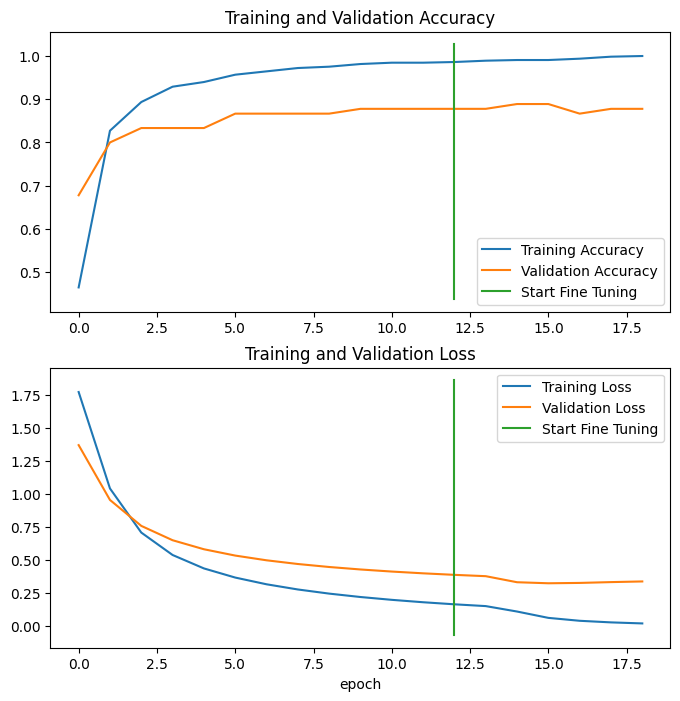

In [ ]:
compare_historys(history_1, history_2, history_1.epoch[-1])

Let's save checkpoint

In [ ]:
model_2.load_weights('checkpoint/model_2')

In [ ]:
model_2.evaluate(val_data)

3/3 [==============================] - 0s 50ms/step - loss: 0.3238 - f1_score: 0.8888 - precision_5: 0.8953 - recall_5: 0.8556 - accuracy: 0.8889


[0.32379528880119324,
 array([0.9       , 0.95238096, 0.9473684 , 0.84210527, 0.8333334 ,
        0.8571428 , 0.7777778 , 0.88888896, 1.        ], dtype=float32),
 0.895348846912384,
 0.855555534362793,
 0.8888888955116272]

It makes a slight improvement :))

In [ ]:
model_2.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_2')

It seems the model has an improvement

## Model 3: Data Augmentation and Fine Tuning 2
fine-tuning 20 layers

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_1')

In [ ]:
model_3.layers[1].trainable = True
for layer in model_2.layers[1].layers[:-20]:
  layer.trainable = False

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=metrics)

In [ ]:
fine_tune_epochs = history_1.epoch[-1] + 20

checkpoint_callback.filepath = 'checkpoint/model_3'

history_3 = model_3.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[early_stopping, checkpoint_callback]
                        )

Epoch 14/33
21/21 [==============================] - ETA: 0s - loss: 0.1311 - f1_score: 0.9581 - precision_5: 0.9627 - recall_5: 0.9431 - accuracy: 0.9676
Epoch 14: val_loss did not improve from 0.29398
21/21 [==============================] - 52s 250ms/step - loss: 0.1311 - f1_score: 0.9581 - precision_5: 0.9627 - recall_5: 0.9431 - accuracy: 0.9676 - val_loss: 0.4152 - val_f1_score: 0.8568 - val_precision_5: 0.8824 - val_recall_5: 0.8333 - val_accuracy: 0.8556
Epoch 15/33
21/21 [==============================] - ETA: 0s - loss: 0.0817 - f1_score: 0.9769 - precision_5: 0.9829 - recall_5: 0.9769 - accuracy: 0.9769
Epoch 15: val_loss did not improve from 0.29398
21/21 [==============================] - 3s 124ms/step - loss: 0.0817 - f1_score: 0.9769 - precision_5: 0.9829 - recall_5: 0.9769 - accuracy: 0.9769 - val_loss: 0.5482 - val_f1_score: 0.8322 - val_precision_5: 0.8333 - val_recall_5: 0.8333 - val_accuracy: 0.8333
Epoch 16/33
21/21 [==============================] - ETA: 0s - loss

In [ ]:
model_3.evaluate(val_data)

3/3 [==============================] - 0s 57ms/step - loss: 0.3047 - f1_score: 0.8904 - precision_5: 0.8989 - recall_5: 0.8889 - accuracy: 0.8889


[0.3047158122062683,
 array([0.9473684 , 0.95238096, 0.9473684 , 0.9       , 0.7826087 ,
        0.8000001 , 0.73684216, 0.9473684 , 1.        ], dtype=float32),
 0.898876428604126,
 0.8888888955116272,
 0.8888888955116272]

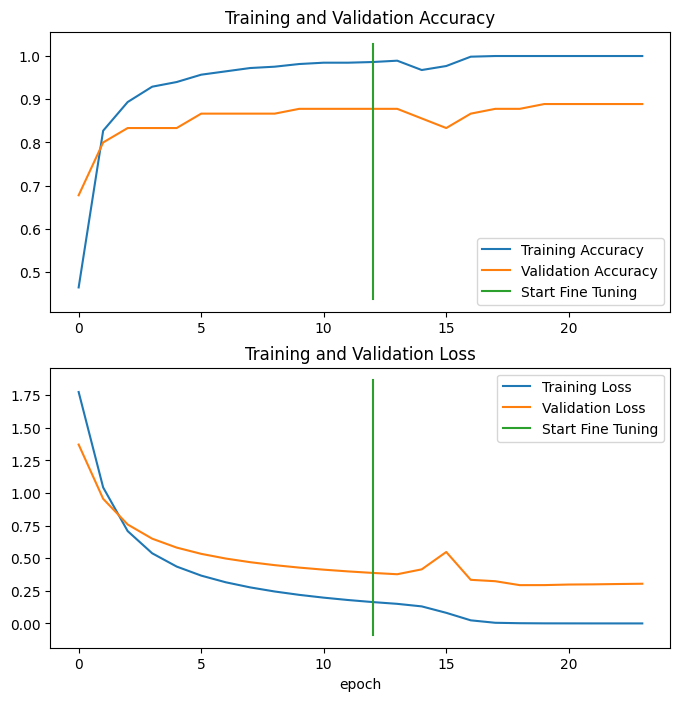

In [ ]:
compare_historys(history_1, history_3, history_1.epoch[-1])

In [ ]:
model_3.load_weights('checkpoint/model_3')

In [ ]:
model_3.evaluate(val_data)

3/3 [==============================] - 0s 53ms/step - loss: 0.2940 - f1_score: 0.8882 - precision_5: 0.8977 - recall_5: 0.8778 - accuracy: 0.8889


[0.29398399591445923,
 array([0.88888896, 0.95238096, 0.90909094, 0.9       , 0.81818175,
        0.8000001 , 0.7777778 , 0.9473684 , 1.        ], dtype=float32),
 0.8977272510528564,
 0.8777777552604675,
 0.8888888955116272]

loading checkpoint because it has slightly better loss

In [ ]:
model_3.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_3')

It seems our model is no longer improving that much, so we will conclude this notebook on model training on **EfficientNetV2B0**. With the same accuracy, model_3 has slightly better loss.

In [ ]:
model_0 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_0')
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_1')
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_2')
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b0/model_3')

In [ ]:
model_0_scores = model_0.evaluate(val_data)
model_1_scores = model_1.evaluate(val_data)
model_2_scores = model_2.evaluate(val_data)
model_3_scores = model_3.evaluate(val_data)

print(f'model_0:\n loss: {model_0_scores[0]} \n accuracy: {model_0_scores[4]}')
print(f'model_1:\n loss: {model_1_scores[0]} \n accuracy: {model_1_scores[4]}')
print(f'model_2:\n loss: {model_2_scores[0]} \n accuracy: {model_2_scores[4]}')
print(f'model_3:\n loss: {model_3_scores[0]} \n accuracy: {model_3_scores[4]}')

3/3 [==============================] - 4s 52ms/step - loss: 0.2940 - f1_score: 0.8882 - precision_5: 0.8977 - recall_5: 0.8778 - accuracy: 0.8889
model_0:
 loss: 0.43001827597618103 
 accuracy: 0.8666666746139526
model_1:
 loss: 0.37759050726890564 
 accuracy: 0.8777777552604675
model_2:
 loss: 0.32379528880119324 
 accuracy: 0.8888888955116272
model_3:
 loss: 0.29398399591445923 
 accuracy: 0.8888888955116272


In [ ]:
model_0_scores[1] = model_0_scores[1].mean()
model_1_scores[1] = model_1_scores[1].mean()
model_2_scores[1] = model_2_scores[1].mean()
model_3_scores[1] = model_3_scores[1].mean()

loss = pd.DataFrame({'model_0': model_0_scores,
                         'model_1': model_1_scores,
                         'model_2': model_2_scores,
                         'model_3': model_3_scores,
                         }, index=['loss', 'f1-score', 'precision', 'recall', 'accuracy'])
loss = loss.T
loss

,loss,f1-score,precision,recall,accuracy
model_0,0.430018,0.868362,0.933333,0.777778,0.866667
model_1,0.377591,0.877255,0.898734,0.788889,0.877778
model_2,0.323795,0.888777,0.895349,0.855556,0.888889
model_3,0.293984,0.888188,0.897727,0.877778,0.888889


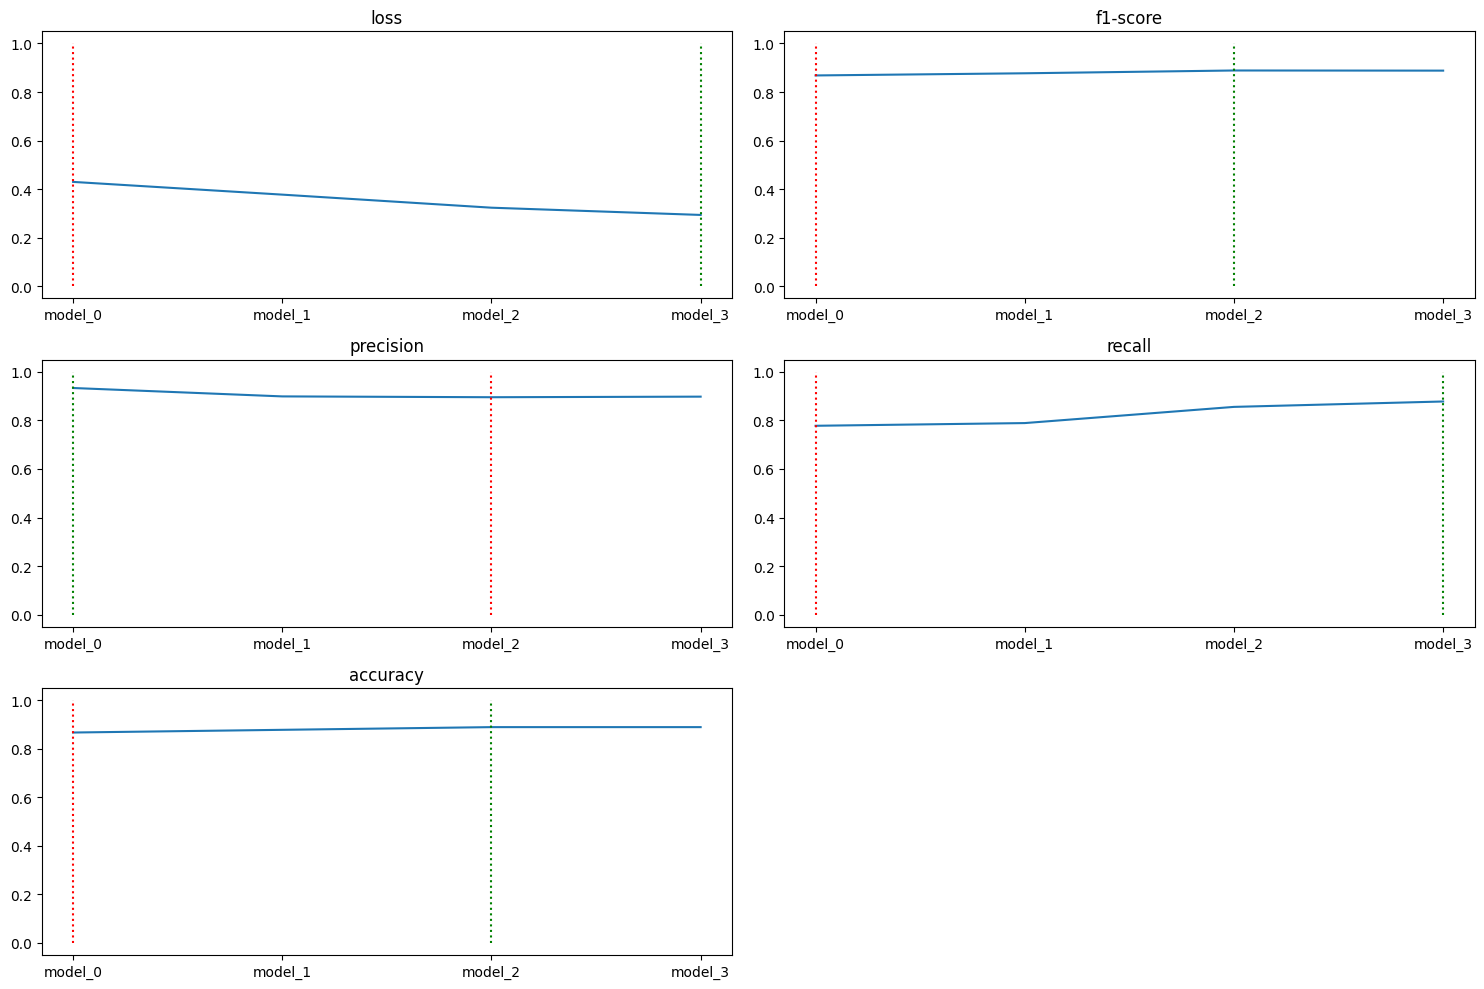

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, index in enumerate(loss.columns):
  plt.subplot(3, 2, 1 + i)
  plt.plot(loss[index])
  plt.title(index)
  if index == 'loss':
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='red', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='green', linestyles='dotted')
  else:
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='red', linestyles='dotted')

fig.tight_layout()

it seems that model_2 has a very **slightly better** f1-score than model_3, but model_3. However, model_3 has a relatively more signifacnt improvement in loss compared to model_3

In [ ]:
model_3.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/best_model_per_version/efficientnetv2b0_fine_tuned')